In [1]:
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install evaluate rouge_score nltk
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:

from datasets import load_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import nltk

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Loading

In [4]:
dataset = load_dataset("knkarthick/samsum")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})


In [5]:
dataset["train"]["dialogue"][3]

"Edward: Rachel, I think I'm in ove with Bella..\nrachel: Dont say anything else..\nEdward: What do you mean??\nrachel: Open your fu**ing door.. I'm outside"

In [6]:
dataset["train"]["summary"][3]

'Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside. '

# 2. EDA

In [7]:
# converting the dataset to pandas dataframes fo visualization uses
df = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

In [8]:
df.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\nJ...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\nSam: i...,"Sam is confused, because he overheard Rick com..."


## 2.1 Text Length Analysis

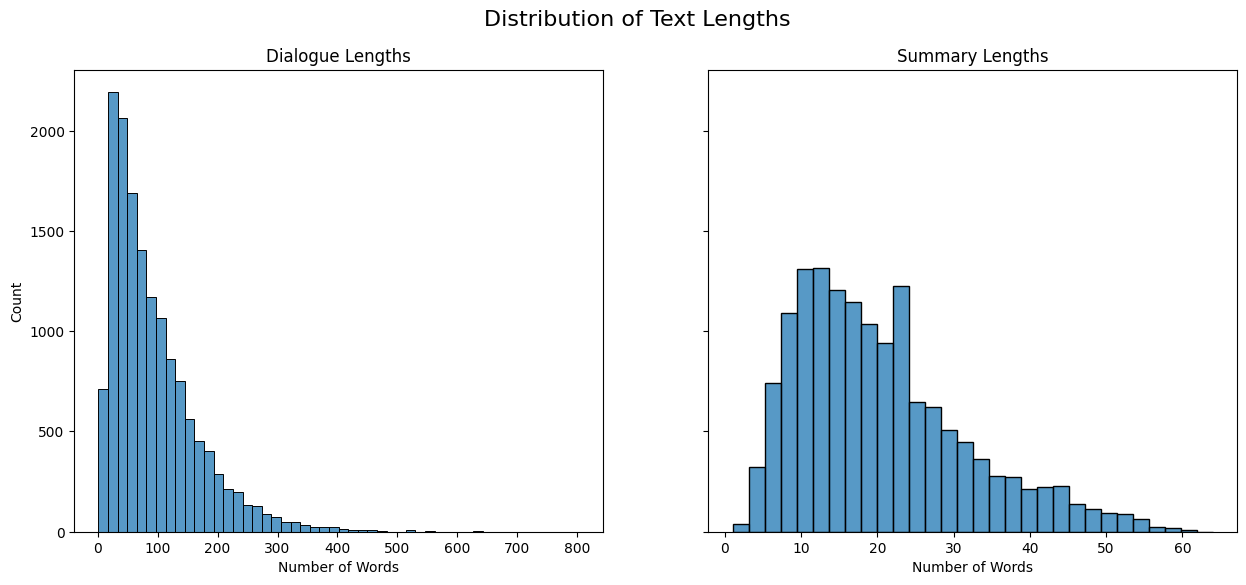

In [9]:
# calculating the length of dialogues & summaries
dialogue_len = df["dialogue"].apply(lambda x : len(str(x).split()))
summary_len = df["summary"].apply(lambda x : len(str(x).split()))

# comparing dialogue and summary lengths
fig, ax = plt.subplots(1, 2 ,figsize=(15, 6), sharey=True)
fig.suptitle("Distribution of Text Lengths", fontsize=16)

# plotting dialogue lengths
sns.histplot(ax=ax[0], x=dialogue_len, bins=50)
ax[0].set_title("Dialogue Lengths")
ax[0].set_xlabel("Number of Words")

# plotting summary lengths
sns.histplot(ax=ax[1], x=summary_len, bins=30)
ax[1].set_title("Summary Lengths")
ax[1].set_xlabel("Number of Words")

plt.show()

## 2.2 Compression Ratio Analysis

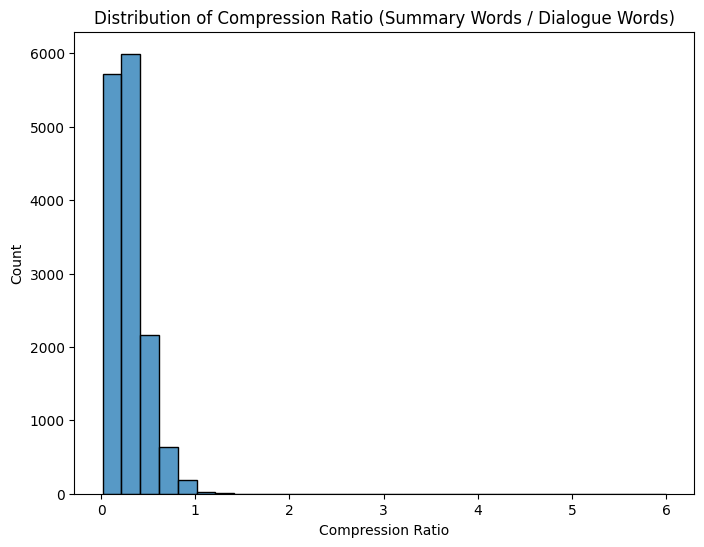

In [10]:
# Compression Ratio Analysis
compression_ratio = summary_len / dialogue_len

# Plotting the Compression Ratios
plt.figure(figsize=(8, 6))
sns.histplot(compression_ratio, bins=30)
plt.title('Distribution of Compression Ratio (Summary Words / Dialogue Words)')
plt.xlabel('Compression Ratio')
plt.show()

In [11]:
# Analyzing the outliers
outliers = df[compression_ratio > 1.0]

num_outliers = len(outliers)
outlier_percentage = (num_outliers / len(df)) * 100
print(f"Found {num_outliers} examples which are outliers")
print(f"That represents {outlier_percentage:.2f}% of the training data")

Found 37 examples which are outliers
That represents 0.25% of the training data


In [12]:
# filtering the outliers
df_filtered = df[compression_ratio <= 1.0].copy()

# 3. Data Preprocessing

In [13]:
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [14]:
def data_preprocessing(examples):
    # adding prefix for the inputs
    prefix = "summarize: "
    inputs = [prefix + example for example in examples["dialogue"]]

    # tokenize the input
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding="max_length")

    # tokenize the target
    with tokenizer.as_target_tokenizer():
        labels_tokenized = tokenizer(examples["summary"], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels_tokenized["input_ids"]
    return model_inputs

In [15]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Convert the filtered pandas DataFrame back to a Dataset object
dataset = Dataset.from_pandas(df_filtered)

# splitting the data
dataset_split = dataset.train_test_split(test_size=0.3, seed=42)
train_set = dataset_split["train"]
temp_set = dataset_split["test"]

temp_split = temp_set.train_test_split(test_size=0.5, seed=42)
val_set = temp_split["train"]
test_set = temp_split["test"]

# Apply the data_preprocessing function using the datasets library's map method
train_tokenized = train_set.map(data_preprocessing, batched=True)
val_tokenized = val_set.map(data_preprocessing, batched=True)
test_tokenized = test_set.map(data_preprocessing, batched=True)

Map:   0%|          | 0/10286 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2204 [00:00<?, ? examples/s]

Map:   0%|          | 0/2205 [00:00<?, ? examples/s]

In [16]:
train_set

Dataset({
    features: ['id', 'dialogue', 'summary', '__index_level_0__'],
    num_rows: 10286
})

# 3. Modeling

## 3.1 Evaluation Metrics for Training

In [17]:
import evaluate
rouge_metric = evaluate.load("rouge")

try:
    nltk.data.find('tokenizers/punkt_tab')
except (LookupError, OSError):
    nltk.download('punkt_tab')

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # replacing -100 with a padding token
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # decoding labels and preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # sentence_level tokenization (for proper ROUGE scoring)
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]


    # compute ROUGE score
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # calculating the average predictions length
    preds_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(preds_lens)

    return {k : round(v, 4) for k, v in result.items()}

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## 3.2 Model Loading & Defining Args

In [18]:
# Loading the base model
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Define training argumetns
batch_size = 8
model_name = "t5-small-samsum-finetuned"
epochs=3
args = Seq2SeqTrainingArguments(
    output_dir=model_name,
    eval_strategy="epoch", # Changed from evaluation_strategy
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=epochs,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=False,
    logging_steps=500,
    eval_steps=500
)

# create a data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## 3.3 Model Training

In [19]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# train
trainer.train()

/tmp/ipython-input-19-520338609.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adammonib2 (adammonib2-cairo-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,0.496600,0.422116,0.392400,0.165800,0.328900,0.364200,16.515400
2,0.459100,0.408081,0.403800,0.174400,0.337400,0.374300,16.800800
3,0.450600,0.406404,0.409600,0.177600,0.341400,0.378800,16.914200


TrainOutput(global_step=3858, training_loss=0.5322102397881128, metrics={'train_runtime': 3349.7641, 'train_samples_per_second': 9.212, 'train_steps_per_second': 1.152, 'total_flos': 8352754619645952.0, 'train_loss': 0.5322102397881128, 'epoch': 3.0})

## 3.4 Evaluating on the Test Set

In [20]:
eval_res = trainer.evaluate(eval_dataset=test_tokenized)
print(eval_res)

{'eval_loss': 0.4198029041290283, 'eval_rouge1': 0.3991, 'eval_rouge2': 0.1722, 'eval_rougeL': 0.3332, 'eval_rougeLsum': 0.368, 'eval_gen_len': 17.02, 'eval_runtime': 190.0154, 'eval_samples_per_second': 11.604, 'eval_steps_per_second': 1.453, 'epoch': 3.0}


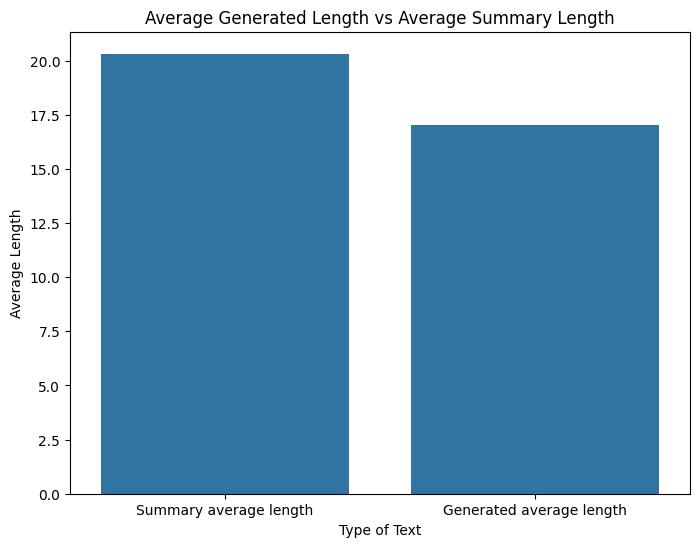

In [23]:
# comparing labels & gen average length
summary_avg_len = np.mean(summary_len)
gen_test_len = eval_res["eval_gen_len"]
labels =["Summary average length", "Generated average length"]

# Plotting Avg labels vs gen lengths
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=[summary_avg_len, gen_test_len])
plt.title('Average Generated Length vs Average Summary Length')
plt.xlabel("Type of Text")
plt.ylabel("Average Length")
plt.show()

## 3.5 saving the model

In [22]:
# Path where you want to save in your Drive
save_path = "/content/drive/MyDrive/Text Summarizer with Transformers/t5-small-samsum-finetuned-final"

# Save model weights, config, and tokenizer
trainer.model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/Text Summarizer with Transformers/t5-small-samsum-finetuned-final/tokenizer_config.json',
 '/content/drive/MyDrive/Text Summarizer with Transformers/t5-small-samsum-finetuned-final/special_tokens_map.json',
 '/content/drive/MyDrive/Text Summarizer with Transformers/t5-small-samsum-finetuned-final/spiece.model',
 '/content/drive/MyDrive/Text Summarizer with Transformers/t5-small-samsum-finetuned-final/added_tokens.json',
 '/content/drive/MyDrive/Text Summarizer with Transformers/t5-small-samsum-finetuned-final/tokenizer.json')

# 4. Load the Model

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(save_path)

# Load model
model = AutoModelForSeq2SeqLM.from_pretrained(save_path)